In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

import warnings
warnings.filterwarnings('ignore')

### Первичное ознакомление с данными и обработка признаков

Загружаем датасет о проведенных боях. [Ссылка на источник](https://www.kaggle.com/datasets/mdabbert/ultimate-ufc-dataset)

In [2]:
data = pd.read_csv('datasets/ufc-master.csv')
data.head()

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,FinishDetails,FinishRound,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,Alexandre Pantoja,Kai Asakura,-250.0,215.0,40.0000,215.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,Rear Naked Choke,2.0,2:05,425.0,300.0,800.0,150.0,2500.0,400.0,350.0
1,Shavkat Rakhmonov,Ian Machado Garry,-210.0,295.0,47.6190,295.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,NaN,5.0,5:00,1500.0,250.0,650.0,180.0,3000.0,240.0,700.0
2,Ciryl Gane,Alexander Volkov,-380.0,300.0,26.3158,300.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,NaN,3.0,5:00,900.0,-160.0,450.0,1100.0,3000.0,350.0,1100.0
3,Bryce Mitchell,Kron Gracie,-950.0,625.0,10.5263,625.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,Elbows,3.0,0:39,639.0,-200.0,1100.0,380.0,1400.0,500.0,4000.0
4,Nate Landwehr,Dooho Choi,-130.0,110.0,76.9231,110.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Blue,...,Elbows,3.0,3:21,801.0,275.0,550.0,500.0,700.0,300.0,250.0


In [3]:
print(f'Размер датасета: {data.shape}')

Размер датасета: (6528, 118)


Отберем только те признаки, которые:
 - кажутся наиболее значимыми для прогноза на основании личной экспертизы
 - могут быть добыты в интернете для последующей загрузки в разработанную модель и получения предсказаний

In [4]:
valuable_features = ['RedFighter',
                     'BlueFighter',                  
                     'WeightClass',
                     'Gender',
                     'Winner',
                     'Finish',
                     'Date',
                     'NumberOfRounds',
                     'RedAge',
                     'RedHeightCms',
                     'RedReachCms',
                     'RedWeightLbs',
                     'RedStance',
                     'RedWins',
                     'RedWinsByDecisionMajority',
                     'RedWinsByDecisionSplit',
                     'RedWinsByDecisionUnanimous',
                     'RedWinsByKO',
                     'RedWinsByTKODoctorStoppage',
                     'RedWinsBySubmission',
                     'RedCurrentWinStreak',
                     'RedLosses',
                     'RedCurrentLoseStreak',
                     'RedAvgSigStrLanded',
                     'RedAvgSigStrPct',                     
                     'RedAvgSubAtt',
                     'RedAvgTDLanded',
                     'RedAvgTDPct',
                     'RedTotalRoundsFought',
                     'RedLongestWinStreak',
                     'BlueAge',
                     'BlueHeightCms',
                     'BlueReachCms',
                     'BlueWeightLbs',
                     'BlueStance',
                     'BlueWins',
                     'BlueWinsByDecisionMajority',
                     'BlueWinsByDecisionSplit',
                     'BlueWinsByDecisionUnanimous',
                     'BlueWinsByKO',
                     'BlueWinsByTKODoctorStoppage',
                     'BlueWinsBySubmission',
                     'BlueCurrentWinStreak',
                     'BlueLosses', 
                     'BlueCurrentLoseStreak',                    
                     'BlueAvgSigStrLanded',                 # Среднее количество значимых ударов, выбрасываемых в минуту синим бойцом
                     'BlueAvgSigStrPct',                    # Соотношение значимых попаданий к общему количеству значимых ударов для синего бойца   
                     'BlueAvgSubAtt',                       # Среднее количесвто попыток болевого приема за 15 минут для синего бойца
                     'BlueAvgTDLanded',                     # Среднее количесвто тейкдаунов за 15 минут для синего бойца
                     'BlueAvgTDPct',                        # Соотношение успешных тейкдаунов к общему количеству попыток для синего бойца
                     'BlueTotalRoundsFought',
                     'BlueLongestWinStreak',
                     'RedOdds',
                     'BlueOdds',
                     'RMatchWCRank',
                     'BMatchWCRank'
                    ]

In [5]:
data = data[valuable_features]

Выведем все уникальные значения целевой переменной

In [6]:
data['Finish'].value_counts()

Finish
U-DEC         2404
KO/TKO        2009
SUB           1157
S-DEC          654
M-DEC           46
DQ              18
Overturned       2
Name: count, dtype: int64

Удалим все строки датасета, где бой завершился дисквалификацией или `No contest`

In [7]:
mask = ~data['Finish'].isin(['DQ', 'Overturned'])
print(f'Найдено {sum(~mask)} строк')
data = data[mask]

Найдено 20 строк


Объединяем признаки `Winner` и `Finish` в один признак `Result`, который будет принимать одно из шести возможных значений и будет являться целевой переменной

In [8]:
def def_target(row):
    if row['Winner'] == 'Red':
        if row['Finish'] == 'KO/TKO':
            return 'Red-KO/TKO'
        elif row['Finish'] == 'SUB':
            return 'Red-Submission'
        else:
            return 'Red-Decision'
    if row['Winner'] == 'Blue':
        if row['Finish'] == 'KO/TKO':
            return 'Blue-KO/TKO'
        elif row['Finish'] == 'SUB':
            return 'Blue-Submission'
        else:
            return 'Blue-Decision'
        
data['Result'] = data.apply(def_target, axis=1)

Объединим несколько признаков между собой для того, чтобы уменьшить количество признаков

In [9]:
# Объединяем признаки, обозначающие количество побед бойца решением судей, в один прзнак (для бойца в красном)
data['RedWinsByDecision'] = data['RedWinsByDecisionMajority'] + data['RedWinsByDecisionSplit'] + data['RedWinsByDecisionUnanimous']
data['RedWinsByKO/TKO'] = data['RedWinsByKO'] + data['RedWinsByTKODoctorStoppage']
# Объединяем признаки, обозначающие количество побед бойца решением судей, в один прзнак (для бойца в синем)
data['BlueWinsByDecision'] = data['BlueWinsByDecisionMajority'] + data['BlueWinsByDecisionSplit'] + data['BlueWinsByDecisionUnanimous']
data['BlueWinsByKO/TKO'] = data['BlueWinsByKO'] + data['BlueWinsByTKODoctorStoppage']

# Удалим признаки, утратившие актуальность после введения новой целевой переменной 
columns_to_drop = ['RedWinsByDecisionMajority',
                   'RedWinsByDecisionSplit',
                   'RedWinsByDecisionUnanimous',
                   'RedWinsByKO',
                   'RedWinsByTKODoctorStoppage',
                   'BlueWinsByDecisionMajority',
                   'BlueWinsByDecisionSplit',
                   'BlueWinsByDecisionUnanimous',
                   'BlueWinsByKO',
                   'BlueWinsByTKODoctorStoppage',
                   'Winner',
                   'Finish'                                             
                    ]

data = data.drop(columns=columns_to_drop, axis=1)

Преобразуем бинарные и ориднальные признаки в числовой вид 

In [10]:
# Бинарные признаки
binary_features = ['Gender', 'NumberOfRounds', 'RedStance', 'BlueStance']
data['Gender'] = data['Gender'].map({'FEMALE': 1, 'MALE': 0}) # Пол бойца
data['NumberOfRounds'] = data['NumberOfRounds'].map({3: 0, 5: 1}) # Количество раундов в бою
data['RedStance'] = data['RedStance'].map({'Southpaw': 1, 'Orthodox': 0}) # Стойка бойца в красном (левосторонняя/правостороння)
data['BlueStance'] = data['BlueStance'].map({'Southpaw': 1, 'Orthodox': 0}) # Стойка бойца в синем (левосторонняя/правостороння)

# Ординальные признаки
ordinal_features = ['WeightClass', 'Result']
# Присваиваем значения от 0 до 7, соответствующие 8 различным весовым категориям
data['WeightClass'] = data['WeightClass'].map({"Women's Strawweight": 0,
                                               'Flyweight': 0,
                                               "Women's Flyweight": 0,
                                               'Bantamweight': 1,
                                               "Women's Bantamweight": 1,
                                               'Featherweight': 2,
                                               "Women's Featherweight": 2,
                                               'Catch Weight': 2,
                                               'Lightweight': 3,
                                               'Welterweight': 4,
                                               'Middleweight': 5,
                                               'Light Heavyweight': 6,
                                               'Heavyweight': 7})

# Целевая переменная
data['Result'] = data['Result'].map({'Red-KO/TKO': 0,
                                     'Red-Submission': 1,
                                     'Red-Decision': 2,
                                     'Blue-KO/TKO': 3,
                                     'Blue-Submission' : 4,
                                     'Blue-Decision': 5                                     
                                    })

Бинаризуем целевую переменную `Result`

In [11]:
data['Result'] = data['Result'].isin([3, 4, 5]).astype(int)

Преобразуем признаки `RMatchWCRank` и `BMatchWCRank`, обозначающие рейтинг бойцов

In [12]:
def ranking_calc(row):
    for col in ['RMatchWCRank', 'BMatchWCRank']:
        if pd.isna(row[col]): # Заменяем NaN на 0 (поскольку в датасете именно такая логика)
            row[col] = 0
        else:
            row[col] = 16 - row[col] # Если бойцы находятся в рейтинге (0 - 15), преобрзуем его в шкалу 1-16, где 16 - чемпион
    return row

data = data.apply(ranking_calc, axis=1)

Создадим новый признак - время, прошедшее с момента последнего боя. Часто большая пауза между боями (например, из-за травмы) негативно сказывается на кондициях бойца, поэтому признак является важным

In [13]:
# Преобразуем столбец 'Date' в формат datetime
data['Date'] = pd.to_datetime(data['Date'])

# Создаем новый столбец для хранения времени с последнего боя
data['RedTimeSinceLastFight'] = None
data['BlueTimeSinceLastFight'] = None

# Итерируем по каждой строке датафрейма
for index, row in data.iterrows():
    # Для бойца в красном
    mask = (data['RedFighter'] == row['RedFighter']) | (data['BlueFighter'] == row['RedFighter'])
    mask = mask & (data['Date'] < row['Date'])
    last_fight = data[mask]['Date'].max()
    if not pd.isnull(last_fight): # Если этот бой для бойца не первый, то вычитаем из даты текущего боя дату последнего боя
        data.loc[index, 'RedTimeSinceLastFight'] = row['Date'] - last_fight
    
    # Для бойца в синем
    mask = (data['RedFighter'] == row['BlueFighter']) | (data['BlueFighter'] == row['BlueFighter'])
    mask = mask & (data['Date'] < row['Date'])
    last_fight = data[mask]['Date'].max()
    if not pd.isnull(last_fight):
        data.loc[index, 'BlueTimeSinceLastFight'] = row['Date'] - last_fight


# Создаем новые признаки для обоих бойцов
data['RedTimeSinceLastFight'] = data['RedTimeSinceLastFight'].apply(lambda x: x.days if not pd.isnull(x) else 0).astype(int)
data['BlueTimeSinceLastFight'] = data['BlueTimeSinceLastFight'].apply(lambda x: x.days if not pd.isnull(x) else 0).astype(int)

# Удаляем старый признак Date
data = data.drop('Date', axis=1)

### Проверка наличия пропусков и их заполнение 

In [14]:
def check_columns_with_nans(df):
    flag = 0
    for col in df.columns:
        isna_sum = 0
        if df[col].isna().any():
            flag = 1 
            isna_sum = df[col].isna().sum()
            print(f'Количество пропусков в столбце {col}: {isna_sum}')
    if not flag:
        print('Пропусков в данных не обнаружено')

check_columns_with_nans(data)

Количество пропусков в столбце NumberOfRounds: 21
Количество пропусков в столбце RedStance: 374
Количество пропусков в столбце RedAvgSigStrLanded: 453
Количество пропусков в столбце RedAvgSigStrPct: 355
Количество пропусков в столбце RedAvgSubAtt: 355
Количество пропусков в столбце RedAvgTDLanded: 355
Количество пропусков в столбце RedAvgTDPct: 365
Количество пропусков в столбце BlueStance: 409
Количество пропусков в столбце BlueAvgSigStrLanded: 926
Количество пропусков в столбце BlueAvgSigStrPct: 761
Количество пропусков в столбце BlueAvgSubAtt: 828
Количество пропусков в столбце BlueAvgTDLanded: 829
Количество пропусков в столбце BlueAvgTDPct: 838
Количество пропусков в столбце RedOdds: 225
Количество пропусков в столбце BlueOdds: 224


Видно, что большинство пропусков приходится на признаки, содержащие статистические показатели бойцов:
`RedAvgSigStrLanded`, `RedAvgSigStrPct`, `RedAvgSubAtt` и т.д

Заполняем очевидные пропуски для тех признаков, где не нужно поднимать статистику, чтобы их заполнить

In [15]:
# По умолчанию считаем, что каждый бой - трехраундовый, т.к. их подавляющее большинство (все, кроеме боев за титул чемпиона) 
data['NumberOfRounds'] = data['NumberOfRounds'].fillna(0) 
# По умолчанию считаем, что каждый боец - левша, т.к. их большинство
data['RedStance'] = data['RedStance'].fillna(1)
data['BlueStance'] = data['BlueStance'].fillna(1)

Теперь посмотрим на распределение признаков, содержащих статистические показатели бойцов

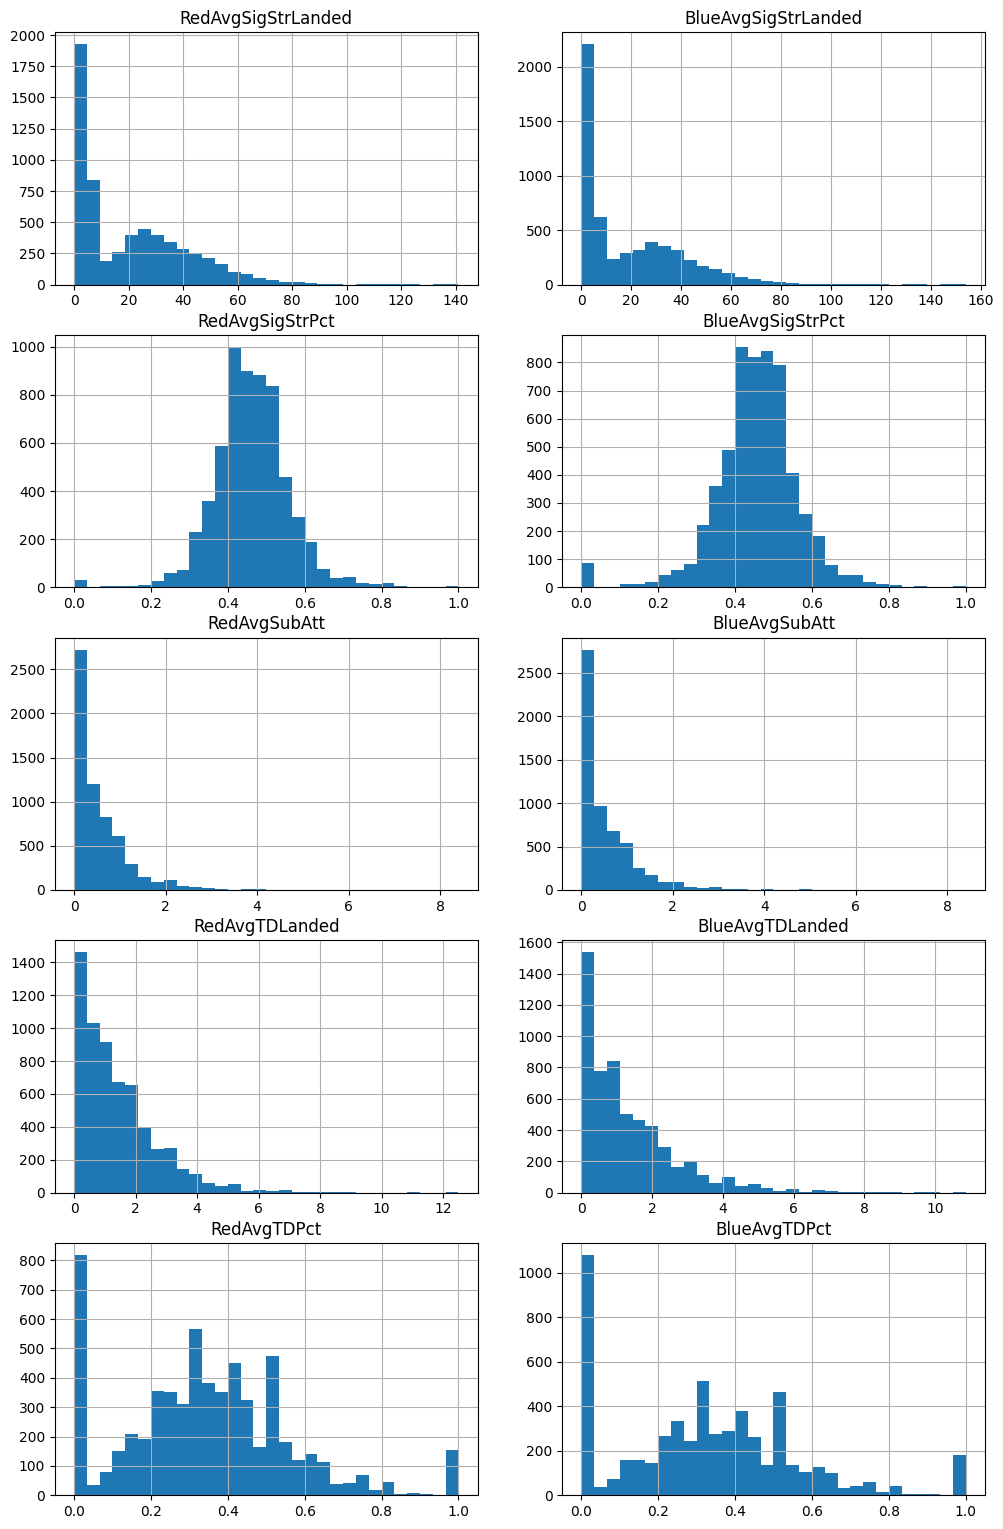

In [16]:
# Соберем признаки, содержащие статистические показатели бойцов, воедино
stats_columns = ['RedAvgSigStrLanded',
                'BlueAvgSigStrLanded',
                'RedAvgSigStrPct',
                'BlueAvgSigStrPct',
                'RedAvgSubAtt',
                'BlueAvgSubAtt',
                'RedAvgTDLanded',
                'BlueAvgTDLanded',
                'RedAvgTDPct',
                'BlueAvgTDPct'
                ]   

def stats_columns_hist(df, columns):
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12, 19))
    for i in range(len(columns)):
        axs[int(i // 2), i % 2].hist(df[columns[i]], bins=30)
        axs[int(i // 2), i % 2].set_title(columns[i])
        axs[int(i // 2), i % 2].grid()

stats_columns_hist(data, stats_columns)

Важно отметить две вещи:
1. Большое количество нулевых значений не является аномалией, т.к. в датасете есть много боев с участием дебютанотов, у которых статистичесие показатели равны 0, т.к. они еще не провели в лиге ни одного боя. Кроме того многие бойцы, например, используют только ударную технику, поэтому такие показатели, как `AvgSubAtt` (среднее количество попыток выхода на болевой прием за 15 мин.) или `AvgTDLanded` (среднее количество сделанных за 15 мин. тейкдаунов) у них могут быть равны 0.
2. Бросается в глаза большое количество аномально больших значений признка `AvgSigStrLanded` (среднее количество выброшенных акцентированных ударов за минуту). Этот показатель обычно находится в районе 4-5 и никак не может превышать 15, в то время как на гистограмме видно много значений, превышающих 20 и даже 100

Заменим пропуски в данных у бойцов-дебютанотов

In [17]:
# Выберем статистические признаки, относящиеся к бойцу в красном
red_stats_cols = [col for col in stats_columns if col.find('Red') > -1]
# Выберем статистические признаки, относящиеся к бойцу в синем
blue_stats_cols = [col for col in stats_columns if col.find('Blue') > -1]
deb_count = len(data[(data['RedTotalRoundsFought'] == 0) | (data['BlueTotalRoundsFought'] == 0)])
print(f'Количество боев с участием дебютантов: {deb_count}')

# Поскольку у дебютантов еще нет статистики (или, во всяком случае, не должно быть), заменяем все NaN нулями
data.loc[data['RedTotalRoundsFought'] == 0, red_stats_cols] = 0
data.loc[data['BlueTotalRoundsFought'] == 0, blue_stats_cols] = 0

Количество боев с участием дебютантов: 1299


Проверим, сколько осталось бойцов-недебютантов с пропусками в данных

In [18]:
# Выберем все признаки, относящиеся к бойцу в красном
red_cols = [col for col in data.columns if col.find('Red') > -1]
# Выберем все признаки, относящиеся к бойцу в синем
blue_cols = [col for col in data.columns if col.find('Blue') > -1]

red_fighter_with_nans = len(data[data['RedAvgSigStrLanded'].isna()][red_cols])
blue_fighter_with_nans = len(data[data['BlueAvgSigStrLanded'].isna()][blue_cols])

print(f'Количество бойцов-недебютантов с пропусками в данных: {red_fighter_with_nans + blue_fighter_with_nans}')

Количество бойцов-недебютантов с пропусками в данных: 176


### Борьба с аномалиями в данных

Посмотрим на признаки, содержащие статистические показатели бойцов

In [19]:
data.loc[:, stats_columns].describe()

,RedAvgSigStrLanded,BlueAvgSigStrLanded,RedAvgSigStrPct,BlueAvgSigStrPct,RedAvgSubAtt,BlueAvgSubAtt,RedAvgTDLanded,BlueAvgTDLanded,RedAvgTDPct,BlueAvgTDPct
count,6422.000000,6418.000000,6508.000000,6508.000000,6508.000000,6508.000000,6508.000000,6507.000000,6501.000000,6499.00000
mean,19.905534,17.130636,0.427705,0.379744,0.496739,0.420116,1.297817,1.102459,0.317673,0.27479
std,19.982434,20.198585,0.149958,0.194921,0.664964,0.628577,1.291792,1.311109,0.227871,0.24798
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,3.740000,2.920000,0.390000,0.341500,0.000000,0.000000,0.333300,0.000000,0.160000,0.00000
50%,11.558450,5.440000,0.450000,0.440000,0.300000,0.142900,1.000000,0.727300,0.330000,0.27100
75%,32.898500,29.741075,0.510000,0.500000,0.750000,0.666700,1.980000,1.670000,0.458000,0.44000
max,141.000000,154.000000,1.000000,1.000000,8.400000,8.400000,12.500000,10.860000,1.000000,1.00000


Видно, что признаки `RedAvgSigStrLanded` и `BlueAvgSigStrLanded` имеют аномально большие значения. Средние значения имеют значения в районе 20, а должны быть в районе 4-5. 

Для примера возьмем одного бойца и посмотрим признаки, описывающие его статистики

In [20]:
data[data['BlueFighter'] == 'Yan Xiaonan'][['BlueFighter'] + stats_columns[1::2]]

,BlueFighter,BlueAvgSigStrLanded,BlueAvgSigStrPct,BlueAvgSubAtt,BlueAvgTDLanded,BlueAvgTDPct
341,Yan Xiaonan,4.97,0.44,0.0,1.00,0.73
827,Yan Xiaonan,4.97,0.44,0.0,1.00,0.73
1112,Yan Xiaonan,4.97,0.44,0.0,1.00,0.73
1432,Yan Xiaonan,4.97,0.44,0.0,1.00,0.73
2067,Yan Xiaonan,6.72,0.42,0.0,1.20,0.75
2397,Yan Xiaonan,6.85,0.40,0.0,0.25,0.25
3230,Yan Xiaonan,96.00,0.45,0.0,0.00,0.00
3494,Yan Xiaonan,0.00,0.00,0.0,0.00,0.00


Значение признака `BlueAvgSigStrLanded` 96 явно аномальное. Значения в последней строке равны 0, т.к. это был дебютный бой бойца в лиге 

Приведем еще пример. Видим, что для всех боев бойца (когда он в синем) приведены аномальные значения 

In [21]:
data[data['BlueFighter'] == 'Marlon Moraes']['BlueAvgSigStrLanded']

2739    22.60
2936    25.75
3247    32.00
3519    44.00
3719     0.00
Name: BlueAvgSigStrLanded, dtype: float64

Из гистограмм, приводимых ранее видно, что значительная часть объектов имеет нормальные значения этих признаков. Воспользуемся этим фактом для того, чтобы заменить аномальные значения этих двух признаков.

In [22]:
# Cоберем реальную статистику по значимым ударам для каждого бойца
fighters_strikes = {}

# Проходим по датафрейму и собираем информацию по бойцам в красном углу
for index, row in data.iterrows():
    fighter = row['RedFighter']
    strikes = row['RedAvgSigStrLanded']

    # Для каждого бойца составляем список со всеми адекватными значениями количества ударов.  
    if 0 < strikes < 15 and pd.notna(strikes): # Считаем, что значения, большие 15, считатются аномалиями (на основании личной экспертизы)  
        if fighter in fighters_strikes:
            fighters_strikes [fighter].append(strikes)
        else:
            fighters_strikes [fighter] = [strikes]

# Проходим по датафрейму и собираем информацию по бойцам в синем
for index, row in data.iterrows():
    fighter = row['BlueFighter']
    strikes = row['BlueAvgSigStrLanded']

    # Для каждого бойца составляем список со всеми адекватными значениями количества ударов.  
    if 0 < strikes < 15 and pd.notna(strikes): 
        if fighter in fighters_strikes:
            fighters_strikes [fighter].append(strikes)
        else:
            fighters_strikes [fighter] = [strikes]

# Усредняем показатель по количеству ударов для каждого бойца
for k, v in fighters_strikes.items():
    fighters_strikes[k] = np.round(np.mean(np.array(v)), 2)


# Пройдемся среди недебютантов, поскольку тех мы уже обработали (бойцы в красном)
for index, row in data.loc[data['RedTotalRoundsFought'] > 0, :].iterrows():
    # Для всех аномальных значений заменяем их на усредненное значение конкретно для этого бойца, взятое из словаря
    if pd.isna(row['RedAvgSigStrLanded']) or row['RedAvgSigStrLanded'] >= 15:
        if row['RedFighter'] in fighters_strikes:
            data.loc[index, 'RedAvgSigStrLanded'] = fighters_strikes[row['RedFighter']]

# бойцы в синем
for index, row in data.loc[data['BlueTotalRoundsFought'] > 0, :].iterrows():        
    if pd.isna(row['BlueAvgSigStrLanded']) or row['BlueAvgSigStrLanded'] >= 15:
        # Для всех аномальных значений заменяем их на усредненное значение конкретно для этого бойца, взятое из словаря
        if row['BlueFighter'] in fighters_strikes:
            data.loc[index, 'BlueAvgSigStrLanded'] = fighters_strikes[row['BlueFighter']]

In [23]:
# Удаляем все остальные пропуски
check_columns_with_nans(data)
data = data.dropna()

Количество пропусков в столбце RedAvgSigStrLanded: 8
Количество пропусков в столбце RedAvgTDPct: 7
Количество пропусков в столбце BlueAvgSigStrLanded: 7
Количество пропусков в столбце BlueAvgTDLanded: 1
Количество пропусков в столбце BlueAvgTDPct: 9
Количество пропусков в столбце RedOdds: 225
Количество пропусков в столбце BlueOdds: 224


Проверим, по какому количеству бойцов исправить статистику по ударам не удалось из-за полного отсутствия адекватных данных по этим бойцам

In [24]:
print(data.loc[(data['RedTotalRoundsFought'] > 0) &  (data['RedAvgSigStrLanded'] == 0), red_cols]['RedFighter'].count())
print(data.loc[(data['BlueTotalRoundsFought'] > 0) &  (data['BlueAvgSigStrLanded'] == 0), blue_cols]['BlueFighter'].count())

12
16


Удалим бои с бойцами-недебютантами, имеющие нулевое количество ударов (бойцы могу не бороться, но таких, кто не наносит удары, не бывает)

In [25]:
red_mask = (data['RedTotalRoundsFought'] > 0) & (data['RedAvgSigStrLanded'] == 0)
blue_mask = (data['BlueTotalRoundsFought'] > 0) & (data['BlueAvgSigStrLanded'] == 0)
data = data.loc[~red_mask]
data = data.loc[~blue_mask]
print(f'Количество удаленных объектов: {sum(red_mask) + sum(blue_mask)}')

Количество удаленных объектов: 28


Проверим, сколько строчек до сих пор содержат аномальные значения по статистике ударов

In [26]:
data[(data['RedAvgSigStrLanded'] > 15) | (data['BlueAvgSigStrLanded'] > 15)][['RedFighter', 
                                                                               'BlueFighter',
                                                                               'RedAvgSigStrLanded',
                                                                               'BlueAvgSigStrLanded',
                                                                               'RedTotalRoundsFought',
                                                                               'BlueTotalRoundsFought']][:5]

,RedFighter,BlueFighter,RedAvgSigStrLanded,BlueAvgSigStrLanded,RedTotalRoundsFought,BlueTotalRoundsFought
2744,Tatiana Suarez,Nina Ansaroff,4.2700,75.1667,8,18
2753,Jimi Manuwa,Aleksandar Rakic,26.0909,4.4200,21,7
2756,Daniel Teymur,Sung Bin Jo,41.0000,0.0000,8,0
2758,Tonya Evinger,Lina Lansberg,20.5000,4.9700,4,13
2759,Stevie Ray,Leonardo Santos,40.2222,2.6700,22,14


Видно, что начиная с 2744 строки в датасете начинаются абсурдные данные

In [27]:
# Удалим эти аномальные строки
data_final = data[(data['RedAvgSigStrLanded'] < 15) & (data['BlueAvgSigStrLanded'] < 15)]

Финальная проверка на пропуски и наличие аномалий

In [28]:
check_columns_with_nans(data_final)

Пропусков в данных не обнаружено


Теперь посмотрим на распределение признаков, описывающих статистики бойцов

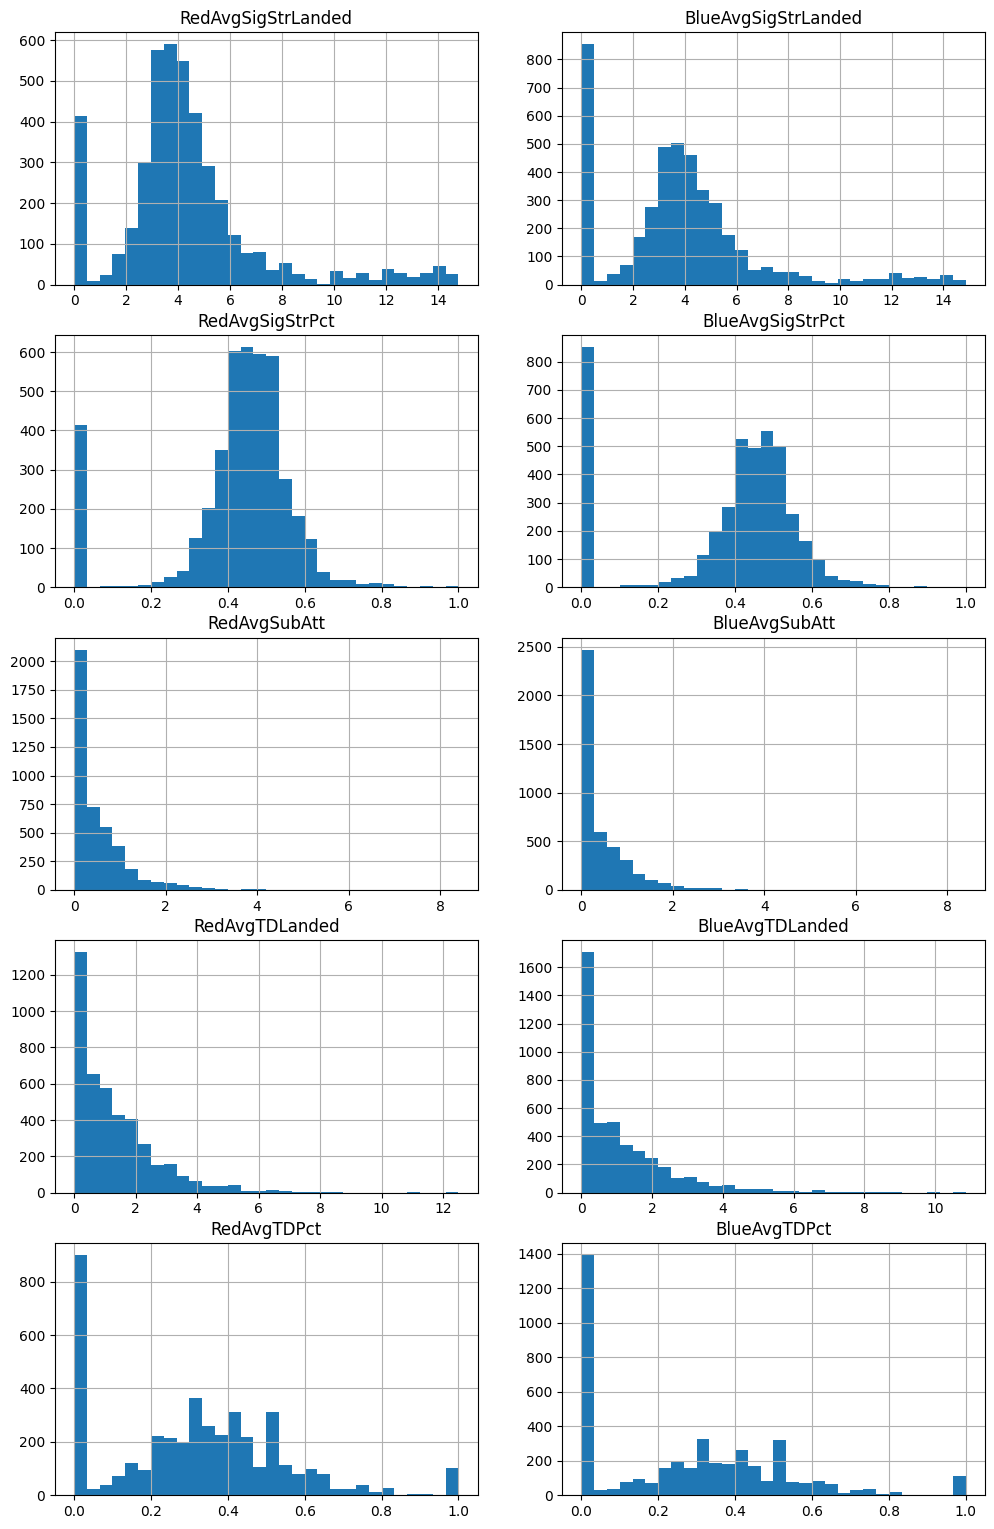

In [29]:
stats_columns_hist(data_final, stats_columns)

### Аугментация данных

Меняем местами бойцов в каждом бою (красный становится синим и наоборот) и, соответственно, результат боя

In [30]:
data_final_reversed_fighters = data_final.copy()

# Итерируемся по всем столбцам, относящимся к бойцам
for r_col, b_col in list(zip(red_cols, blue_cols)):
    data_final_reversed_fighters[b_col] = data_final[r_col]
    data_final_reversed_fighters[r_col] = data_final[b_col]

data_final_reversed_fighters['Result'] = ~data_final['Result'].astype(bool)
data_final_reversed_fighters['Result'] = data_final_reversed_fighters['Result'].astype(int)
data_final_reversed_fighters.head()

,RedFighter,BlueFighter,WeightClass,Gender,NumberOfRounds,RedAge,RedHeightCms,RedReachCms,RedWeightLbs,RedStance,...,BlueOdds,RMatchWCRank,BMatchWCRank,Result,RedWinsByDecision,RedWinsByKO/TKO,BlueWinsByDecision,BlueWinsByKO/TKO,RedTimeSinceLastFight,BlueTimeSinceLastFight
0,Kai Asakura,Alexandre Pantoja,0,0,1.0,31,172.72,175.26,125,0.0,...,-250.0,16.0,0.0,1,0,0,6,2,0,217
1,Ian Machado Garry,Shavkat Rakhmonov,4,0,0.0,27,190.50,187.96,170,0.0,...,-210.0,13.0,9.0,1,5,3,0,1,161,357
2,Alexander Volkov,Ciryl Gane,7,0,0.0,36,200.66,203.20,250,0.0,...,-380.0,14.0,13.0,1,5,6,3,4,168,462
3,Kron Gracie,Bryce Mitchell,2,0,0.0,36,175.26,177.80,145,1.0,...,-950.0,3.0,0.0,1,0,0,6,0,581,357
4,Dooho Choi,Nate Landwehr,2,0,0.0,33,177.80,177.80,145,0.0,...,-130.0,0.0,0.0,0,0,4,2,1,140,252


Объединяем базовый и реверсированный датасеты в один

In [31]:
# Создаем списки строк из каждого датафрейма
rows_data_final = [data_final.iloc[i] for i in range(len(data_final))]
rows_data_final_reversed_fighters = [data_final_reversed_fighters.iloc[i] for i in range(len(data_final_reversed_fighters))]

# Чередуем строки из двух списков
rows_combined = [val for pair in zip(rows_data_final, rows_data_final_reversed_fighters) for val in pair]

# Создаем новый датафрейм из объединенных строк
data_combined = pd.DataFrame(rows_combined)#.drop(columns=['WeightClass', 'Gender', 'NumberOfRounds'])
data_combined.head()

,RedFighter,BlueFighter,WeightClass,Gender,NumberOfRounds,RedAge,RedHeightCms,RedReachCms,RedWeightLbs,RedStance,...,BlueOdds,RMatchWCRank,BMatchWCRank,Result,RedWinsByDecision,RedWinsByKO/TKO,BlueWinsByDecision,BlueWinsByKO/TKO,RedTimeSinceLastFight,BlueTimeSinceLastFight
0,Alexandre Pantoja,Kai Asakura,0,0,1.0,34,165.10,170.18,125,0.0,...,215.0,16.0,0.0,0,6,2,0,0,217,0
0,Kai Asakura,Alexandre Pantoja,0,0,1.0,31,172.72,175.26,125,0.0,...,-250.0,16.0,0.0,1,0,0,6,2,0,217
1,Shavkat Rakhmonov,Ian Machado Garry,4,0,0.0,30,185.42,195.58,170,0.0,...,295.0,13.0,9.0,0,0,1,5,3,357,161
1,Ian Machado Garry,Shavkat Rakhmonov,4,0,0.0,27,190.50,187.96,170,0.0,...,-210.0,13.0,9.0,1,5,3,0,1,161,357
2,Ciryl Gane,Alexander Volkov,7,0,0.0,34,193.04,205.74,245,0.0,...,300.0,14.0,13.0,0,3,4,5,6,462,168


Наконец, удалим всех бойцов, у которых есть 0 в статистических показателях по ударам (дебютанты)

In [32]:
# Определяем столбцы, которые должны быть ненулевыми
columns_to_check = ['RedAvgSigStrLanded', 'BlueAvgSigStrLanded']

# Создаем маску для фильтрации строк
mask = ~data_final[columns_to_check].eq(0).any(axis=1)

# Применяем маску для фильтрации датафрейма
data_final = data_final.loc[mask]
data_combined = data_combined.loc[mask]
print(f'Количество удаленных объектов: {sum(mask)}')

Количество удаленных объектов: 3298


### Анализ признаков и Feature engineering

Посмотрим на наиболее значимые признаки при помощи расчета взаимной информации

In [33]:
X = data_combined.drop(['Result', 'RedFighter', 'BlueFighter'], axis=1)
y = data_combined['Result']

feature_names = X.columns.tolist()  # список названий признаков

# Расчет взаимной информации для каждого признака
mi = mutual_info_classif(X, y)

# Отбор k наиболее информативных признаков
k = 15
selector = SelectKBest(mutual_info_classif, k=k)
X_selected = selector.fit_transform(X, y)

# Получение индексов отобранных признаков
indices = selector.get_support(indices=True)

# Вывод названий отобранных признаков
print("Отобранные признаки:")
for index in indices:
    print(feature_names[index])

Отобранные признаки:
RedAge
RedLosses
RedAvgSigStrLanded
RedAvgSigStrPct
RedAvgTDPct
BlueWins
BlueCurrentWinStreak
BlueLosses
BlueAvgSigStrLanded
BlueAvgSigStrPct
BlueAvgTDLanded
BlueAvgTDPct
BlueTotalRoundsFought
RedOdds
BlueOdds


Создадим новые признаки, которые будут представлять собой разность соответствующих признаков двух бойцов

In [34]:
# Создаем новые признаки
def create_new_features(df): 
    df_copy = df.copy()   
    df_copy['Age_diff'] = df_copy['RedAge'] - df_copy['BlueAge']
    df_copy['Height_diff'] = df_copy['RedHeightCms'] - df_copy['BlueHeightCms']
    df_copy['Reach_diff'] = df_copy['RedReachCms'] - df_copy['BlueReachCms']
    df_copy['Weight_diff'] = df_copy['RedWeightLbs'] - df_copy['BlueWeightLbs']   
    df_copy['WinsByKO/TKO_diff'] = df_copy['RedWinsByKO/TKO'] - df_copy['BlueWinsByKO/TKO']
    df_copy['WinsBySubmission_diff'] = df_copy['RedWinsBySubmission'] - df_copy['BlueWinsBySubmission']
    df_copy['WinsByDecision_diff'] = df_copy['RedWinsByDecision'] - df_copy['BlueWinsByDecision']
    df_copy['Loss_diff'] = df_copy['RedLosses'] - df_copy['BlueLosses']
    # Находим разницу между числом побед-поражений для обоих бойцов
    # df_copy['Red_Blue_wins_loss_diff'] = df_copy['Red_wins_loss_diff'] - df_copy['Blue_wins_loss_diff']
    # Находим разницу в статистических показателях для обоих бойцов
    df_copy['AvgSigStrLanded_diff'] = df_copy['RedAvgSigStrLanded'] - df_copy['BlueAvgSigStrLanded']
    df_copy['AvgSigStrPct_diff'] = df_copy['RedAvgSigStrPct'] - df_copy['BlueAvgSigStrPct']
    df_copy['TDAvgLanded_diff'] = df_copy['RedAvgTDLanded'] - df_copy['BlueAvgTDLanded']
    df_copy['AvgTDPct_diff'] = df_copy['RedAvgTDPct'] - df_copy['BlueAvgTDPct']
    df_copy['AvgSubAtt_diff'] = df_copy['RedAvgSubAtt'] - df_copy['BlueAvgSubAtt']
    # Находим разницу для других признаков
    df_copy['LongestWinStreak_diff'] = df_copy['RedLongestWinStreak'] - df_copy['BlueLongestWinStreak']
    df_copy['TotalRoundsFought_diff'] = df_copy['RedTotalRoundsFought'] - df_copy['BlueTotalRoundsFought']
    df_copy['TimeSinceLastFight_diff'] = df_copy['RedTimeSinceLastFight'] - df_copy['BlueTimeSinceLastFight']
    df_copy['Rank_diff'] = df_copy['RMatchWCRank'] - df_copy['BMatchWCRank']
    
    return df_copy

# Находим разницу в текущих сериях побед/поражений для двух бойцов
def red_blue_streak_diff_calc(row):
    # Если оба бойца одержали победы в предыдущих боях, то вычитаем серию побед бойца в синем из оной для бойца в красном
    if row['RedCurrentWinStreak'] > 0: 
        if row['BlueCurrentWinStreak'] > 0:
            return row['RedCurrentWinStreak'] - row['BlueCurrentWinStreak']
        else: # Если боец в синем идет после поражения, то добавляем количество его поражений к количетву побед бойца в красном
            return row['RedCurrentWinStreak'] + row['BlueCurrentLoseStreak']
    else: # Если боец в синем идет после победы, а оец в красном - после поражения, то вычитаем первое из второго
        if row['BlueCurrentWinStreak'] > 0:
            return -row['RedCurrentLoseStreak'] - row['BlueCurrentWinStreak']
        else:
            return -row['RedCurrentLoseStreak'] + row['BlueCurrentLoseStreak']     

 Убираем исходные признаки и оставляем только что созданные

In [35]:
# Убираем исходные признаки и оставляем только созданные
def drop_features(df):
    df_copy = df.copy()
    df_copy = df_copy.drop(columns=[
                          'RedAge',
                          'RedHeightCms',
                          'RedReachCms',
                          'RedWeightLbs',
                          'BlueAge',
                          'BlueHeightCms',
                          'BlueReachCms',
                          'BlueWeightLbs',
                          'RedWins',
                          'RedLosses',
                          'BlueWins',
                          'BlueLosses',
                          'RedCurrentWinStreak',
                          'RedCurrentLoseStreak',
                          'RedTotalRoundsFought',
                          'BlueCurrentWinStreak',
                          'BlueCurrentLoseStreak',
                          #'Red_wins_loss_diff',
                          #'Blue_wins_loss_diff',                                     
                          'WeightClass',
                          'RedAvgSigStrLanded',
                          'RedAvgSigStrPct',
                          'BlueAvgSigStrLanded',
                          'BlueAvgSigStrPct',
                          'RedAvgTDLanded',
                          'RedAvgTDPct', 
                          'BlueAvgTDLanded',
                          'BlueAvgTDPct',
                          'RedAvgSubAtt',                          
                          'BlueAvgSubAtt',
                          'Gender',
                          'NumberOfRounds',
                          'RedWinsBySubmission',
                          'BlueWinsBySubmission',
                          'RedWinsByDecision',
                          'RedWinsByKO/TKO',
                          'BlueWinsByDecision',
                          'BlueWinsByKO/TKO',
                          'BlueTotalRoundsFought',
                          'RedLongestWinStreak',
                          'BlueLongestWinStreak',
                          'RedTimeSinceLastFight',
                          'BlueTimeSinceLastFight',
                          'RMatchWCRank',
                          'BMatchWCRank'
                          ], axis=1)
    return df_copy

Применяем функции по созданию новых признаков и удалению старых к датасету

In [36]:
data_featured = create_new_features(data_combined.loc[:, :])
data_featured['Curr_streak_diff'] = data_featured.apply(red_blue_streak_diff_calc, axis=1)
data_featured = drop_features(data_featured)

In [37]:
data_featured.head()

,RedFighter,BlueFighter,RedStance,BlueStance,RedOdds,BlueOdds,Result,Age_diff,Height_diff,Reach_diff,...,AvgSigStrLanded_diff,AvgSigStrPct_diff,TDAvgLanded_diff,AvgTDPct_diff,AvgSubAtt_diff,LongestWinStreak_diff,TotalRoundsFought_diff,TimeSinceLastFight_diff,Rank_diff,Curr_streak_diff
1,Shavkat Rakhmonov,Ian Machado Garry,0.0,0.0,-210.0,295.0,0,3,-5.08,7.62,...,-1.38,0.06,0.72,-0.26,1.5,-2,-9,196,4.0,-2
1,Ian Machado Garry,Shavkat Rakhmonov,0.0,0.0,295.0,-210.0,1,-3,5.08,-7.62,...,1.38,-0.06,-0.72,0.26,-1.5,2,9,-196,4.0,2
2,Ciryl Gane,Alexander Volkov,0.0,0.0,-380.0,300.0,0,-2,-7.62,2.54,...,0.36,0.03,0.13,-0.42,0.3,3,-11,294,1.0,-3
2,Alexander Volkov,Ciryl Gane,0.0,0.0,300.0,-380.0,1,2,7.62,-2.54,...,-0.36,-0.03,-0.13,0.42,-0.3,-3,11,-294,1.0,3
3,Bryce Mitchell,Kron Gracie,1.0,1.0,-950.0,625.0,0,-6,2.54,0.00,...,-1.44,0.14,2.98,0.16,1.1,5,15,-224,3.0,1


Сделаем отдельный датасет для оценки моделей, не содержащий реверсированных данных

In [38]:
data_featured_test = create_new_features(data_final.loc[:, :])
data_featured_test['Curr_streak_diff'] = data_featured_test .apply(red_blue_streak_diff_calc, axis=1)
data_featured_test  = drop_features(data_featured_test )

In [39]:
data_featured_test.head()

,RedFighter,BlueFighter,RedStance,BlueStance,RedOdds,BlueOdds,Result,Age_diff,Height_diff,Reach_diff,...,AvgSigStrLanded_diff,AvgSigStrPct_diff,TDAvgLanded_diff,AvgTDPct_diff,AvgSubAtt_diff,LongestWinStreak_diff,TotalRoundsFought_diff,TimeSinceLastFight_diff,Rank_diff,Curr_streak_diff
1,Shavkat Rakhmonov,Ian Machado Garry,0.0,0.0,-210.0,295.0,0,3,-5.08,7.62,...,-1.38,0.06,0.72,-0.26,1.5,-2,-9,196,4.0,-2
2,Ciryl Gane,Alexander Volkov,0.0,0.0,-380.0,300.0,0,-2,-7.62,2.54,...,0.36,0.03,0.13,-0.42,0.3,3,-11,294,1.0,-3
3,Bryce Mitchell,Kron Gracie,1.0,1.0,-950.0,625.0,0,-6,2.54,0.00,...,-1.44,0.14,2.98,0.16,1.1,5,15,-224,3.0,1
4,Nate Landwehr,Dooho Choi,0.0,0.0,-130.0,110.0,1,3,-2.54,5.08,...,1.84,-0.07,0.25,0.04,0.2,0,2,112,0.0,0
5,Dominick Reyes,Anthony Smith,1.0,0.0,-380.0,300.0,0,-2,0.00,2.54,...,1.63,0.01,-0.11,0.02,-0.3,3,-42,21,1.0,2


Посмотрим на корреляции оставшихся признаков между собой и между ними и целевой переменной

<Axes: >

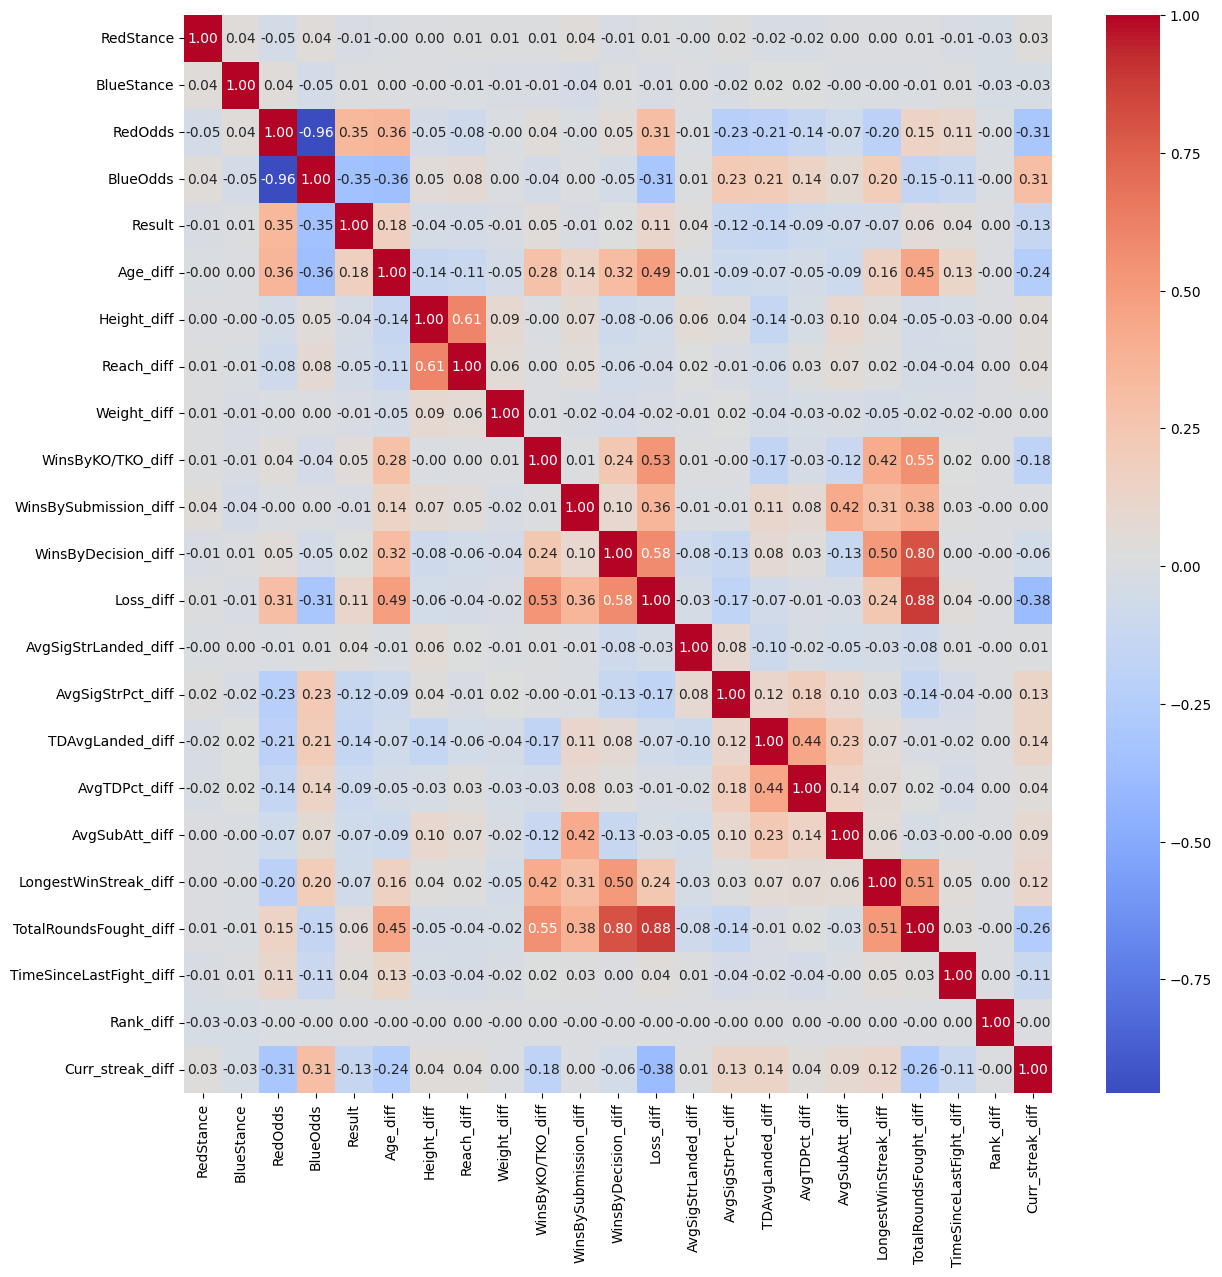

In [40]:
corr_matrix = data_featured.drop(['RedFighter', 'BlueFighter'], axis=1).corr()
plt.figure(figsize=(14, 14))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')

Экспортируем полученный датасет для дальнейшего обучения моделей

In [41]:
data_featured.to_csv('data_preprocessed/data_final_6596.csv')
data_featured_test.to_csv('data_preprocessed/data_test_final_3298.csv')